# Preface

**There are really a few question marks here for me...**
1. Can we train a model to discern between the cases of local extirpation, abundance decrease, no change, and abundance increase?
2. Can we train two seperate models to predict the continuous responses for abundance increases and decreases?
3. When we compose these three models, does it perform fairly well in predicting RRs? What are its distribution qualities, compared to our other two-stage hurdle models?

# Setup

In [89]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from flaml import AutoML

from imblearn.over_sampling import SMOTENC
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix, median_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from utils import preprocess_data
from custom_metrics import get_DI_cats, balanced_accuracy_FLAML, median_absolute_error_FLAML, median_absolute_error_range, \
                           balanced_accuracy_DI_cats, wasserstein_distance_range

In [2]:
# Set random seed
np.random.seed(1693)

# Data preprocessing

In [3]:
# Read dataset
data = pd.read_csv('/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_extended.csv')

In [4]:
# Train test split - just random for now!
train_pct = 0.8

idxs = [i for i in range(len(data))]
train_idxs = list(np.random.choice(idxs, replace = False, size = int(train_pct * len(idxs))))
test_idxs = [i for i in idxs if i not in train_idxs]

train_test_idxs = {'train' : train_idxs,
                   'test' : test_idxs}

In [5]:
# Apply preprocessing
governance_cols = ['Corruption', 'Government_Effectiveness', 'Political_Stability', 'Regulation', 
                   'Rule_of_Law', 'Accountability']

pp_data = preprocess_data(data, include_indicators = False, include_categorical = False,
                          standardize = True, log_trans_cont = False, polynomial_features = 0,
                          embeddings_to_use = None, embeddings_args = None, train_test_idxs = train_test_idxs,
                          pca_save_fp = None, pca_cols = governance_cols, dataset = 'mammals_recreated')
pp_data.head()

,Body_Mass,Stunting_Pct,Literacy_Rate,Dist_Settlement_KM,Travel_Time_Large,Livestock_Biomass,Population_Density,Percent_Settlement_50km,PC_0,Protected_Area,Response_Ratio
0,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.377193
1,4.526840,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.865690
2,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.833333
3,4.526840,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.900862
4,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.956140


In [6]:
# Generate DI categories for model to predict
cat_encoding = {'extirpated' : 0,
                'decrease' : 1, 
                'no change' : 2,
                'increase' : 3}
cat_decoding = {v : k for k, v in cat_encoding.items()}

pp_data['DI_cat'] = get_DI_cats(pp_data['Response_Ratio'], neighborhood = 0)
pp_data['DI_cat'] = pp_data['DI_cat'].apply(lambda x: cat_encoding[x])
pp_data['DI_cat'].value_counts()

DI_cat
1    1198
2    1020
3     655
0     408
Name: count, dtype: int64

# Testing the initial classification model

In [7]:
# Split up training/testing sets
predictors = [c for c in pp_data.columns if c not in ['Response_Ratio', 'DI_cat']]
response = 'DI_cat'

X_train, y_train = pp_data.iloc[train_idxs][predictors], pp_data.iloc[train_idxs][response]
X_test, y_test = pp_data.iloc[test_idxs][predictors], pp_data.iloc[test_idxs][response]

In [8]:
# Resampling the dataset using SMOTE
categorical_features = ['Protected_Area']
smote = SMOTENC(categorical_features = categorical_features, random_state = 1693)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
# Setting up the model
time_budget_mins = 2

model = AutoML()
model_settings = {'time_budget' : time_budget_mins * 60,  # in seconds
                  'metric' : balanced_accuracy_FLAML,
                  'task' : 'classification',
                  'log_file_name' : 'scratch_dir/flaml_three_part_model.txt',
                  'seed' : 1693,
                  'estimator_list' : ['rf', 'xgboost'],
                  'early_stop' : True,
                  'verbose' : 5,
                  'keep_search_state' : True,
                  'eval_method' : 'cv'}

In [10]:
# Training the model
model.fit(X_train, y_train, **model_settings)

[flaml.automl.logger: 09-18 17:04:05] {1680} INFO - task = classification
[flaml.automl.logger: 09-18 17:04:05] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-18 17:04:05] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 09-18 17:04:05] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost']
[flaml.automl.logger: 09-18 17:04:05] {2219} INFO - iteration 0, current learner rf
[flaml.tune.tune: 09-18 17:04:05] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.3162277660168379, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl.logger: 09-18 17:04:05] {2345} INFO - Estimated sufficient time budget=1950s. Estimated necessary time budget=2s.
[flaml.automl.logger: 09-18 17:04:05] {2392} INFO -  at 0.2s,	estimator rf's best error=0.6899,	best estimator rf's best error=0.6899
[flaml.automl.logger: 09-18 17:04:05] {2219} INFO - iteration 1, current learner xgboost
[flaml.tune.tune: 09-18 17:04:05] {811} INFO - trial 1 confi

In [11]:
# Checking which model was chosen + the hyperparams
print(model.best_estimator)
print(model.best_config)

xgboost
{'n_estimators': 13, 'max_leaves': 509, 'min_child_weight': 0.7327307367951938, 'learning_rate': 0.006072779022641041, 'subsample': 0.9053230720231273, 'colsample_bylevel': 0.7321437753224438, 'colsample_bytree': 0.9788004655974184, 'reg_alpha': 0.001855735547079837, 'reg_lambda': 0.05322070906967519}


Balanced accuracy: 55.55%


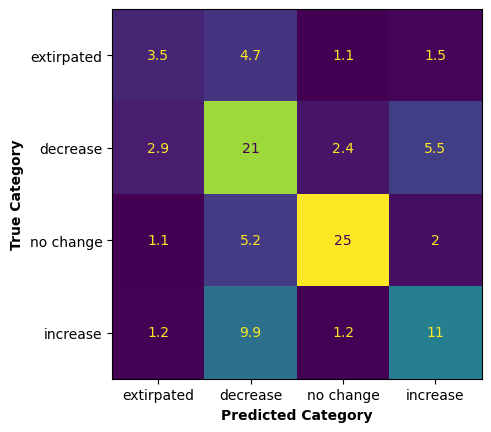

In [12]:
# Some basic model evaluation
y_pred = model.predict(X_test)

#  get balanced accuracy
ba = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced accuracy: {round(ba * 100, 2)}%')

#  display confusion matrix
class_names = [cat_decoding[c] for c in model.classes_]

cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
cm = (cm / len(y_test)) * 100
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(colorbar = False)

plt.ylabel('True Category', weight = 'bold')
plt.xlabel('Predicted Category', weight = 'bold')

plt.show()

In [16]:
# Checking per-class balanced accuracy scores
for c in model.classes_:
    y_pred_c = (y_pred == c).astype(int)
    y_test_c = (y_test == c).astype(int)
    
    ba = balanced_accuracy_score(y_test_c, y_pred_c)
    print(f'BA for class "{cat_decoding[c]}" is {round(ba * 100, 2)}%')

BA for class "extirpated" is 63.3%
BA for class "decrease" is 68.65%
BA for class "no change" is 84.08%
BA for class "increase" is 68.15%


In [17]:
# Comparing to a random guesser, as a baseline
probs = y_train.value_counts().sort_index().values / len(y_train)

bas = []
for i in range(1000):
    y_guess = np.random.choice(model.classes_, size = len(y_test), replace = True, p = probs)
    ba = balanced_accuracy_score(y_test, y_guess)
    bas.append(ba)

print(f'Random guessing (based on class probs.) achieves BA of {round(np.mean(bas) * 100, 2)}% over 1000 runs')

Random guessing (based on class probs.) achieves BA of 25.01% over 1000 runs


In [18]:
# Same thing but on a class-per-class basis, just to check what our baseline is...
bas = {0 : [], 1 : [], 2 : [], 3 : []}
for i in range(1000):
    y_guess = np.random.choice(model.classes_, size = len(y_test), replace = True, p = probs)
    
    for c in model.classes_:
        y_guess_c = (y_guess == c).astype(int)
        y_test_c = (y_test == c).astype(int)
        
        ba = balanced_accuracy_score(y_test_c, y_guess_c)
        bas[c].append(ba)

for c in model.classes_:
    print(f'Random guessing achieves BA of {round(np.mean(bas[c]) * 100, 2)}% over 1000 runs for class "{cat_decoding[c]}"')

Random guessing achieves BA of 50.05% over 1000 runs for class "extirpated"
Random guessing achieves BA of 50.07% over 1000 runs for class "decrease"
Random guessing achieves BA of 49.97% over 1000 runs for class "no change"
Random guessing achieves BA of 49.96% over 1000 runs for class "increase"


## Comparing to full grid search

In [42]:
# Setting up the grid search for hyperparameter tuning
params = {'max_features' : np.linspace(0.1, 1, num = 5),
          'n_estimators' : np.linspace(50, 500, num = 10).astype(np.int32),
          'max_leaf_nodes' : np.linspace(30, 130, num = 5).astype(np.int32)}

#  setting up the sklearn models
rf = RandomForestClassifier(random_state = 1693)
grid_search = GridSearchCV(rf, param_grid = params, refit = True, scoring = 'balanced_accuracy', 
                           verbose = 2, cv = 5)

#  running hyperparam tuning
grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=50; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=50; total time=   0.0s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=50; total time=   0.0s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=50; total time=   0.0s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=50; total time=   0.0s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=100; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=100; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=100; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=100; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=100; total time=   0.1s
[CV] END max_features=0.1, max_leaf_nodes=30, n_estimators=150; total time=   0.1s
[CV] END max_features=0.1, m

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1693),
             param_grid={'max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'max_leaf_nodes': array([ 30,  55,  80, 105, 130], dtype=int32),
                         'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500], dtype=int32)},
             scoring='balanced_accuracy', verbose=2)

{'max_features': 0.55, 'max_leaf_nodes': 130, 'n_estimators': 300}
Balanced accuracy: 56.74%


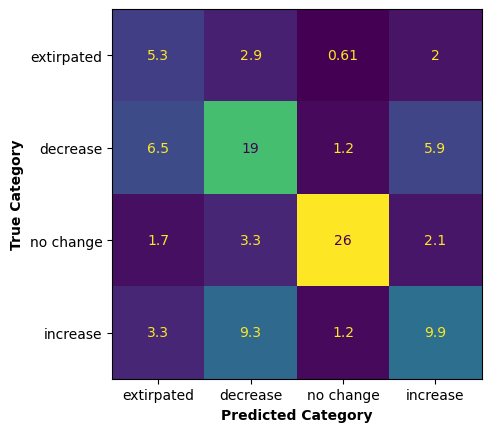

In [44]:
# Pulling out the best model
print(grid_search.best_params_)
rf_model = grid_search.best_estimator_

#  evaluating on the test set
y_pred = rf_model.predict(X_test)

#  get balanced accuracy
ba = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced accuracy: {round(ba * 100, 2)}%')

#  display confusion matrix
class_names = [cat_decoding[c] for c in model.classes_]

cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
cm = (cm / len(y_test)) * 100
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(colorbar = False)

plt.ylabel('True Category', weight = 'bold')
plt.xlabel('Predicted Category', weight = 'bold')

plt.show()

# Testing the two separate regression models

In [19]:
# Pulling out the train/test sets for these models
pp_data_train = pp_data.iloc[train_idxs]
pp_data_test = pp_data.iloc[test_idxs]

#  abundance decrease
train_dec = pp_data_train[pp_data_train['DI_cat'] == cat_encoding['decrease']]
X_train_dec, y_train_dec = train_dec[predictors], train_dec['Response_Ratio']

test_dec = pp_data_test[pp_data_test['DI_cat'] == cat_encoding['decrease']]
X_test_dec, y_test_dec = test_dec[predictors], test_dec['Response_Ratio']

#  abundance increase
upper_rr_thresh = 5

train_inc = pp_data_train[(pp_data_train['DI_cat'] == cat_encoding['increase']) & (pp_data_train['Response_Ratio'] <= upper_rr_thresh)]
X_train_inc, y_train_inc = train_inc[predictors], train_inc['Response_Ratio']

test_inc = pp_data_test[(pp_data_test['DI_cat'] == cat_encoding['increase']) & (pp_data_test['Response_Ratio'] <= upper_rr_thresh)]
X_test_inc, y_test_inc = test_inc[predictors], test_inc['Response_Ratio']

## Abundance decrease model

In [20]:
# Setting up the decrease model
time_budget_mins = 2

model_dec = AutoML()
model_dec_settings = {'time_budget' : time_budget_mins * 60,  # in seconds
                      'metric' : median_absolute_error_FLAML,
                      'task' : 'regression',
                      'log_file_name' : 'scratch_dir/flaml_decrease_model.txt',
                      'seed' : 1693,
                      'estimator_list' : ['rf', 'xgboost'],
                      'early_stop' : True,
                      'verbose' : 5,
                      'keep_search_state' : True,
                      'eval_method' : 'cv'}

In [21]:
# Training the decrease model
model_dec.fit(X_train_dec, y_train_dec, **model_dec_settings)

[flaml.automl.logger: 09-18 17:07:19] {1680} INFO - task = regression
[flaml.automl.logger: 09-18 17:07:19] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-18 17:07:19] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 09-18 17:07:19] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost']
[flaml.automl.logger: 09-18 17:07:19] {2219} INFO - iteration 0, current learner rf
[flaml.tune.tune: 09-18 17:07:19] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 1.0, 'max_leaves': 4}
[flaml.automl.logger: 09-18 17:07:19] {2345} INFO - Estimated sufficient time budget=1954s. Estimated necessary time budget=2s.
[flaml.automl.logger: 09-18 17:07:19] {2392} INFO -  at 0.2s,	estimator rf's best error=0.2190,	best estimator rf's best error=0.2190
[flaml.automl.logger: 09-18 17:07:19] {2219} INFO - iteration 1, current learner xgboost
[flaml.tune.tune: 09-18 17:07:19] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 

In [57]:
model_dec.best_estimator

'xgboost'

In [22]:
# Evaluating the model fit
y_pred_dec = model_dec.predict(X_test_dec)

med_ae = median_absolute_error(y_test_dec, y_pred_dec)
print(f'MedAE for predicting decreases: {round(med_ae, 3)}')

MedAE for predicting decreases: 0.192


In [23]:
# Establishing a random guessing baseline - predicting the median
y_guess_dec = np.repeat(np.median(y_train_dec), len(y_test_dec))

med_ae = median_absolute_error(y_test_dec, y_guess_dec)
print(f'MedAE for random guessing of decreases: {round(med_ae, 3)}')

MedAE for random guessing of decreases: 0.22


## Abundance increase model

In [24]:
# Setting up the increase model
time_budget_mins = 2

model_inc = AutoML()
model_inc_settings = {'time_budget' : time_budget_mins * 60,  # in seconds
                      'metric' : median_absolute_error_FLAML,
                      'task' : 'regression',
                      'log_file_name' : 'scratch_dir/flaml_decrease_model.txt',
                      'seed' : 1693,
                      'estimator_list' : ['rf', 'xgboost'],
                      'early_stop' : True,
                      'verbose' : 5,
                      'keep_search_state' : True,
                      'eval_method' : 'cv'}

In [25]:
# Training the increase model
model_inc.fit(X_train_inc, y_train_inc, **model_inc_settings)

[flaml.automl.logger: 09-18 17:09:19] {1680} INFO - task = regression
[flaml.automl.logger: 09-18 17:09:19] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-18 17:09:19] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 09-18 17:09:19] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost']
[flaml.automl.logger: 09-18 17:09:19] {2219} INFO - iteration 0, current learner rf
[flaml.tune.tune: 09-18 17:09:19] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 1.0, 'max_leaves': 4}
[flaml.automl.logger: 09-18 17:09:19] {2345} INFO - Estimated sufficient time budget=1633s. Estimated necessary time budget=2s.
[flaml.automl.logger: 09-18 17:09:19] {2392} INFO -  at 0.2s,	estimator rf's best error=0.6611,	best estimator rf's best error=0.6611
[flaml.automl.logger: 09-18 17:09:19] {2219} INFO - iteration 1, current learner xgboost
[flaml.tune.tune: 09-18 17:09:19] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_leaves': 4, 

In [56]:
model_inc.best_estimator

'rf'

In [26]:
# Evaluating the model fit
y_pred_inc = model_inc.predict(X_test_inc)

med_ae = median_absolute_error(y_test_inc, y_pred_inc)
print(f'MedAE for predicting increases: {round(med_ae, 3)}')

MedAE for predicting increases: 0.51


In [27]:
# Establishing a random guessing baseline - predicting the median
y_guess_inc = np.repeat(np.median(y_train_inc), len(y_test_inc))

med_ae = median_absolute_error(y_test_inc, y_guess_inc)
print(f'MedAE for random guessing of increases: {round(med_ae, 3)}')

MedAE for random guessing of increases: 0.515


# Composing the three models

In [39]:
# Generating the overall three-part model prediction
missing_val = 1e5
overall_predictions = np.repeat(missing_val, pp_data_test.shape[0])

#  first, predict with the classifier
pred_class = model.predict(X_test)
overall_predictions[pred_class == cat_encoding['extirpated']] = 0
overall_predictions[pred_class == cat_encoding['no change']] = 1

#  then, fill in for decreases
pred_dec = model_dec.predict(X_test)
overall_predictions[pred_class == cat_encoding['decrease']] = pred_dec[pred_class == cat_encoding['decrease']]

#  finally, fill in for increases
pred_inc = model_inc.predict(X_test)
overall_predictions[pred_class == cat_encoding['increase']] = pred_inc[pred_class == cat_encoding['increase']]

In [41]:
# Checking if there are any values missing a prediction...
num_missing = (overall_predictions == missing_val).sum()
print(f'{num_missing} missing values after filling in')

0 missing values after filling in


In [97]:
# Evaluating the composite predictions
rr_test = pp_data_test['Response_Ratio']

#  MedAE overall
med_ae = median_absolute_error(rr_test, overall_predictions)
print(f'MedAE overall: {round(med_ae, 3)}')

#  MedAE, 0-1 range
med_ae_01 = median_absolute_error_range(rr_test, overall_predictions, lower_bound = 0, upper_bound = 1, 
                                        return_pct_kept = False)
print(f'MedAE 0-1 range: {round(med_ae_01, 3)}')

#  balanced accuracy for the four categories
ba_di = balanced_accuracy_DI_cats(rr_test, overall_predictions, neighborhood = 0.05)
print(f'Balanced accuracy for the four DI categories: {round(ba_di * 100, 2)}%')

#  wasserstein distance (0-2 range)
wd_2 = wasserstein_distance_range(rr_test, overall_predictions, upper_bound = 2)
print(f'WD for 0-2 range: {round(wd_2, 3)}')

MedAE overall: 0.283
MedAE 0-1 range: 0.132
Balanced accuracy for the four DI categories: 54.4%
WD for 0-2 range: 0.154


In [98]:
# Again, random (median) guessing baseline
rr_train = pp_data_train['Response_Ratio']
y_guess_overall = np.repeat(np.median(rr_train), len(rr_test))

#  MedAE overall
med_ae = median_absolute_error(rr_test, y_guess_overall)
print(f'MedAE for random guessing overall: {round(med_ae, 3)}')

#  MedAE, 0-1 range
med_ae_01 = median_absolute_error_range(rr_test, y_guess_overall, lower_bound = 0, upper_bound = 1, 
                                        return_pct_kept = False)
print(f'MedAE 0-1 range: {round(med_ae_01, 3)}')

#  balanced accuracy for the four categories
ba_di = balanced_accuracy_DI_cats(rr_test, y_guess_overall, neighborhood = 0.05)
print(f'Balanced accuracy for the four DI categories: {round(ba_di * 100, 2)}%')

#  wasserstein distance (0-2 range)
wd_2 = wasserstein_distance_range(rr_test, y_guess_overall, upper_bound = 2)
print(f'WD for 0-2 range: {round(wd_2, 3)}')

MedAE for random guessing overall: 0.342
MedAE 0-1 range: 0.162
Balanced accuracy for the four DI categories: 25.0%
WD for 0-2 range: 0.368


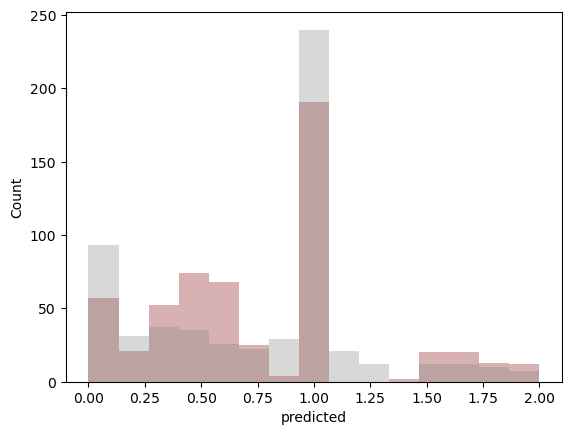

In [94]:
# Looking at the distributional properties
max_val = 2

d = pd.DataFrame({'actual' : rr_test, 'predicted' : overall_predictions})
d = d[(d['actual'] <= max_val) & (d['actual'] >= 0)]

sns.histplot(data = d, x = 'predicted', stat = 'count', kde = False, legend = False, bins = 15, 
             color = 'maroon', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val))
sns.histplot(data = d, x = 'actual', stat = 'count', kde = False, legend = False, bins = 15, 
             color = 'grey', zorder = 100, alpha = 0.3, ec = None, binrange = (0, max_val))

plt.show()